In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
import scipy

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 2
width = 128  # 1024
bias = True
n_steps = 1000
base_lr = 1e-3
p = 3  # p = 2
batch_size = None
tgt_func_name = "target_func"

SEED = 42
pause = 1e-6

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/neurons_dynamic/bias/{}'.format(width))
# FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/standard_nn/{}'.format(width))

In [8]:
set_random_seeds(SEED)

## Set up data, model, loss and optimizer

In [7]:
# val data
X_val = torch.randn(size=(n_samples, input_dim), requires_grad=False)
target_func = TARGET_FUNCS_DICT['{}_{}d'.format(tgt_func_name, input_dim)]
# y_val = torch.reshape(0.5 * (X_val ** 2).sum(dim=1), (len(X_val), 1))
# y_val = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X_val[:, 0] ** p), (len(X_val), 1))
y_val = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X_val ** p).sum(dim=1), (len(X_val), 1))

# network
network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network.train()

# loss & optimizer
loss = LOSS_DICT['mse'](reduction='mean')
optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)

In [10]:
## Traditional NN
network = torch.nn.Sequential(
    torch.nn.Linear(in_features=input_dim, out_features=width, bias=bias),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=width, out_features=1, bias=bias)
)
network.train()
optimizer = torch.optim.SGD(network.parameters(), lr=base_lr)

with torch.no_grad():
    torch.nn.init.kaiming_normal_(network[0].weight.detach(), mode='fan_out', nonlinearity='relu')
    torch.nn.init.kaiming_normal_(network[2].weight.detach(), mode='fan_out', nonlinearity='relu')

## Plot initial neurons

In [8]:
signs = network.output_layer.weight.data.detach().clone().numpy()[0]
init_neurons = network.input_layer.weight.data.detach().clone().numpy()

In [20]:
signs = np.sign(network[2].weight.data.detach().clone().numpy()[0])
init_neurons = network[0].weight.data.detach().clone().numpy()

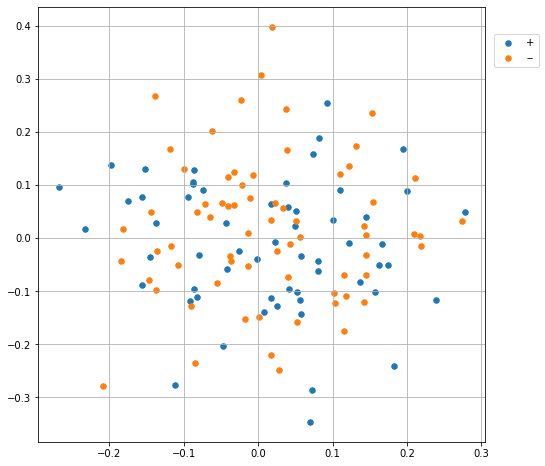

In [23]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, init_neurons, signs, s=30)
plt.show()

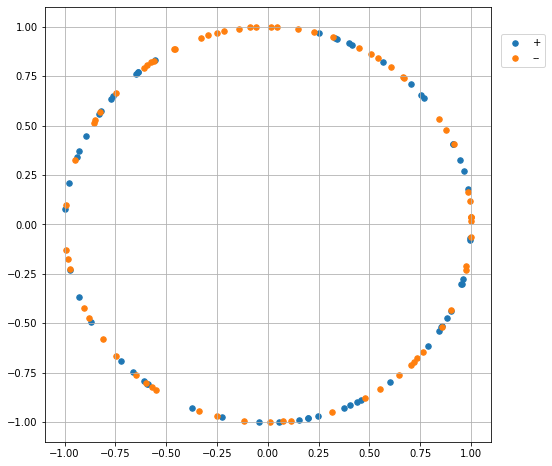

In [24]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, init_neurons / np.sqrt((init_neurons ** 2).sum(axis=1, keepdims=True)),
                signs, s=30)
plt.show()

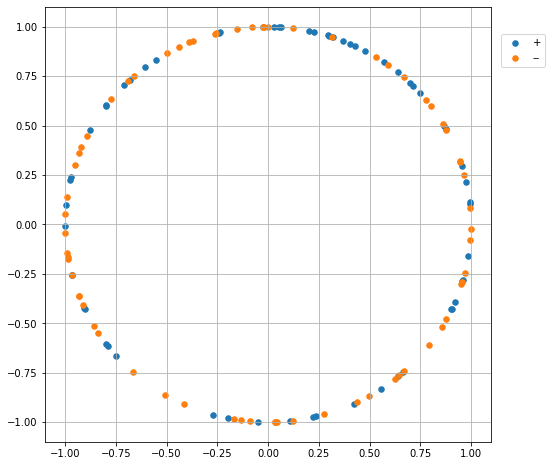

In [9]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, init_neurons, signs, s=30)
plt.show()

## Train for a few steps

In [10]:
## IP-model with shpere init
bs = 256
neurons = [network.input_layer.weight.data.detach().clone().numpy()]
normalized_neurons = [neurons[0] / np.sqrt((neurons[0] ** 2).sum(axis=1, keepdims=True))]
train_losses = []
val_losses = []
for i in range(5*n_steps):
    optimizer.zero_grad()
    X = torch.randn(size=(bs, input_dim), requires_grad=False)
    #y = torch.reshape(0.5 * (X ** 2).sum(dim=1), (len(X), 1))
    #y = torch.reshape(0.5 * (X[:, 0] ** 2), (len(X), 1))
    #y = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X[:, 0] ** p), (len(X), 1))
    y = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (X ** p).sum(dim=1), (len(X), 1))

    # forward
    y_hat = network.forward(X)
    # loss_ = loss(y_hat, y)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean()

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())
    
    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        # val_loss = loss(y_hat_val, y_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
        val_losses.append(val_loss.detach().item())

        neurons_i = network.input_layer.weight.data.detach().clone().numpy()
        neurons.append(neurons_i)
        normalized_neurons.append(neurons_i / np.sqrt((neurons_i ** 2).sum(axis=1, keepdims=True)))
    
neurons = np.array(neurons)
normalized_neurons = np.array(normalized_neurons)

In [25]:
## Standard NN
bs = 256
neurons = [network[0].weight.data.detach().clone().numpy()]
normalized_neurons = [neurons[0] / np.sqrt((neurons[0] ** 2).sum(axis=1, keepdims=True))]
train_losses = []
val_losses = []
for i in range(n_steps):
    optimizer.zero_grad()
    X = torch.randn(size=(bs, input_dim), requires_grad=False)
    #y = torch.reshape(0.5 * (X ** 2).sum(dim=1), (len(X), 1))
    y = torch.reshape(0.5 * (X[:, 0] ** 2), (len(X), 1))

    # forward
    y_hat = network.forward(X)
    # loss_ = loss(y_hat, y)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean()

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())
    
    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        # val_loss = loss(y_hat_val, y_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
        val_losses.append(val_loss.detach().item())
        
        neurons_i = network[0].weight.data.detach().clone().numpy()
        neurons.append(neurons_i)
        normalized_neurons.append(neurons_i / np.sqrt((neurons_i ** 2).sum(axis=1, keepdims=True)))
    
neurons = np.array(neurons)
normalized_neurons = np.array(normalized_neurons)

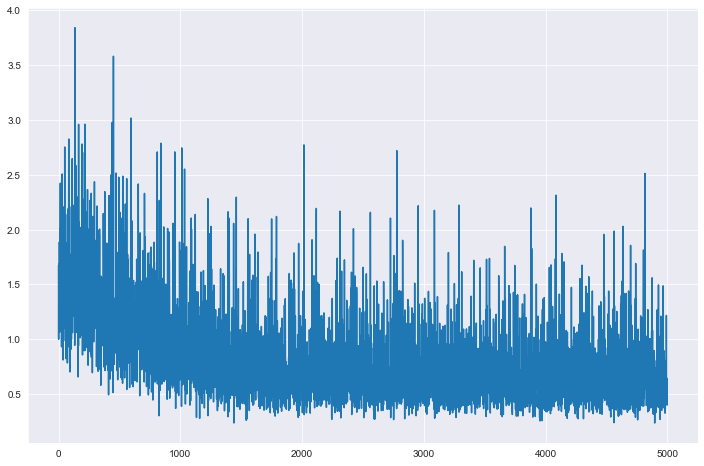

In [11]:
n = 5000
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(train_losses))[:n], train_losses[:n])
plt.show()

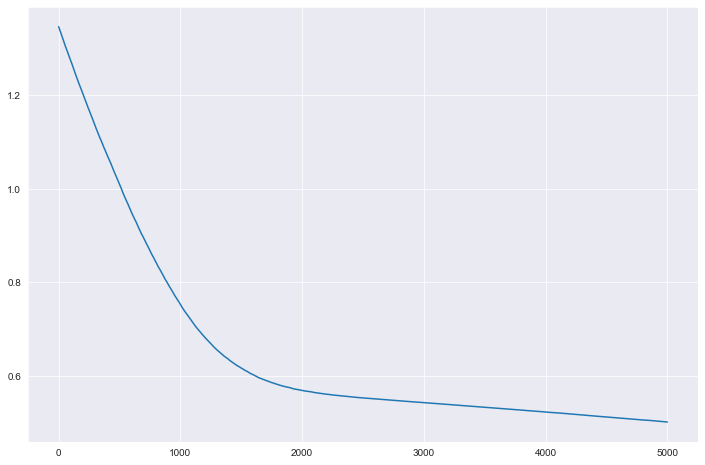

In [12]:
n = 6000
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(val_losses))[:n], val_losses[:n])
plt.show()

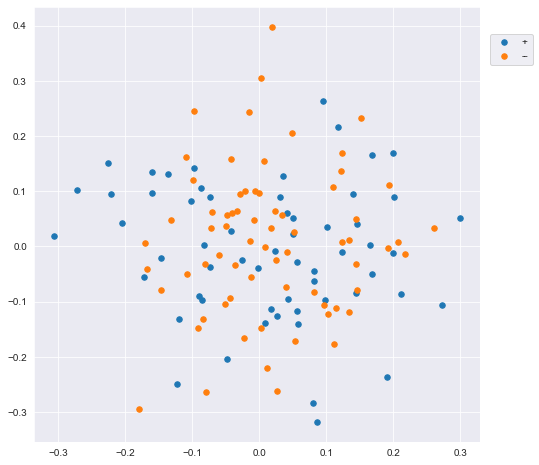

In [28]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[1000, :], signs, s=30)
plt.show()

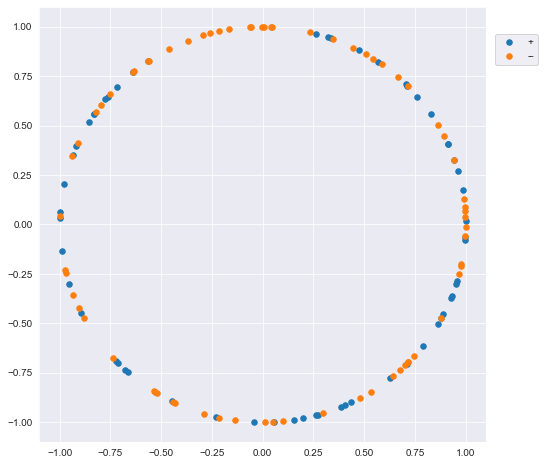

In [32]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, normalized_neurons[1000, :], signs, s=30)
plt.show()

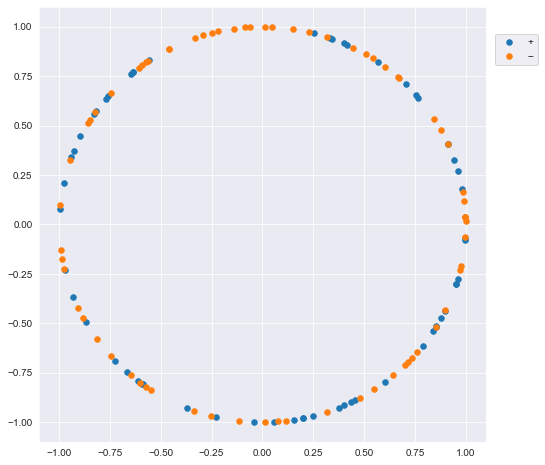

In [33]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, normalized_neurons[0, :], signs, s=30)
plt.show()

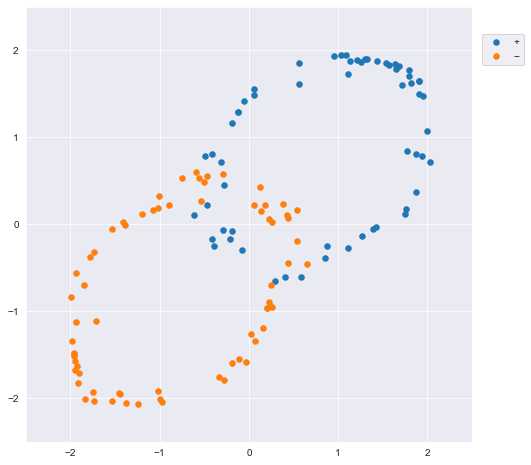

In [21]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[5000], signs, s=30)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()

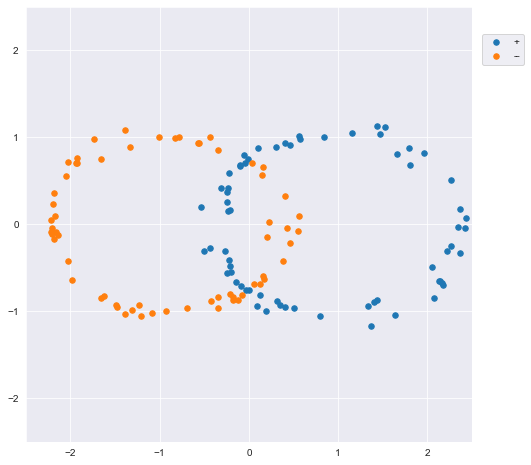

In [14]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[5000], signs, s=30)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()

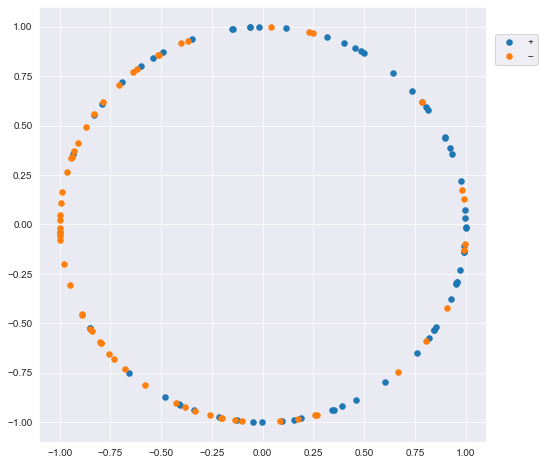

In [15]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, normalized_neurons[5000, :, :], signs, s=30)
plt.show()

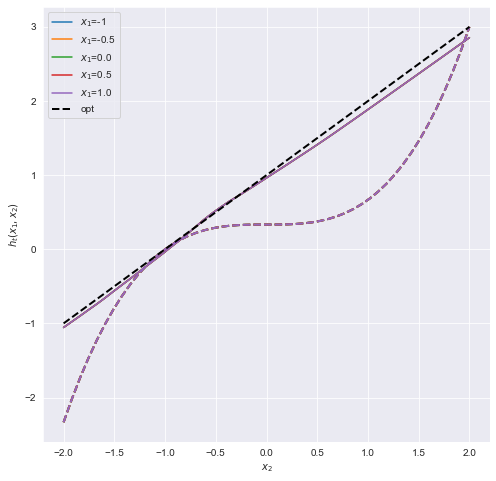

In [24]:
num = 50
consts = [-1, -0.5, 0., 0.5, 1.0]

xs = np.linspace(-2, 2, num=num)
X = np.zeros((50, 2))
X[:, 1] = xs
Xs = []
for c in consts:
    X[:, 0] = c
    Xs.append(X)

fig = plt.figure(figsize=(8,8))
M = 1
palette = sns.color_palette()
with torch.no_grad():
    for i, X in enumerate(Xs):
        color = palette[i]
        x = torch.tensor(X, dtype=torch.float32)
        y_hat = network.forward(x)
        y = torch.reshape((1/scipy.special.factorial2(p, exact=True)) * (x ** p).sum(dim=1), (len(X), 1))
        
        plt.plot(xs, y_hat.detach().numpy(), label='$x_1$={}'.format(consts[i]), color=color)
        plt.plot(xs, y.detach().numpy(), color=color, linestyle='dashed', 
                 linewidth=2)
        
        M = max(M, y_hat.detach().abs().max())

if M <= 1:
    plt.ylim(-1.05 * M, 1.05 * M)

plt.plot(xs, xs + 1, linestyle='dashed', linewidth=2, label='opt', color='k')
plt.xlabel('$x_2$')
plt.ylabel('$h_t(x_1, x_2)$')
plt.legend()
plt.show()

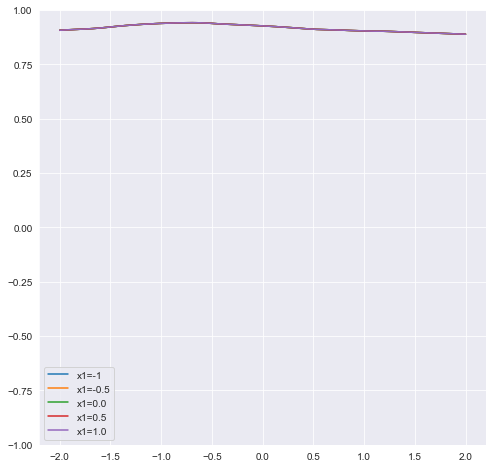

In [30]:
num = 50
consts = [-1, -0.5, 0., 0.5, 1.0]

xs = np.linspace(-2, 2, num=num)
X = np.zeros((50, 2))
X[:, 1] = xs
Xs = []
for c in consts:
    X[:, 0] = c
    Xs.append(X)

fig = plt.figure(figsize=(8,8))
with torch.no_grad():
    for i, X in enumerate(Xs):
        y_hat = network.forward(torch.tensor(X, dtype=torch.float32))
        plt.plot(xs, y_hat.detach().numpy(), label='x1={}'.format(consts[i]))

plt.ylim(-1, 1)
plt.legend()
plt.show()

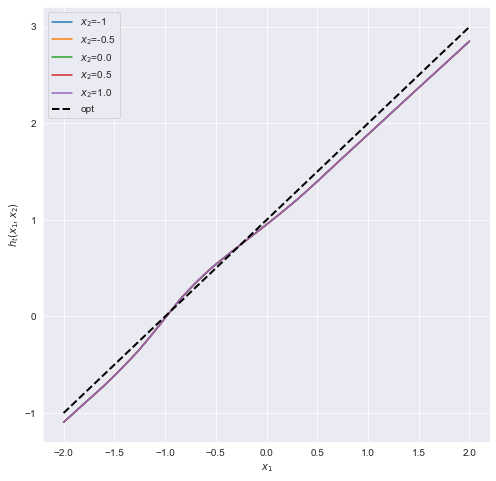

In [19]:
num = 50
consts = [-1, -0.5, 0., 0.5, 1.0]

xs = np.linspace(-2, 2, num=num)
X = np.zeros((50, 2))
X[:, 0] = xs
Xs = []
for c in consts:
    X[:, 1] = c
    Xs.append(X)

fig = plt.figure(figsize=(8,8))
with torch.no_grad():
    for i, X in enumerate(Xs):
        y_hat = network.forward(torch.tensor(X, dtype=torch.float32))
        plt.plot(xs, y_hat.detach().numpy(), label='$x_2$={}'.format(consts[i]))

plt.plot(xs, xs + 1, linestyle='dashed', linewidth=2, label='opt', color='k')
plt.xlabel('$x_1$')
plt.ylabel('$h_t(x_1, x_2)$')
plt.legend()
plt.show()

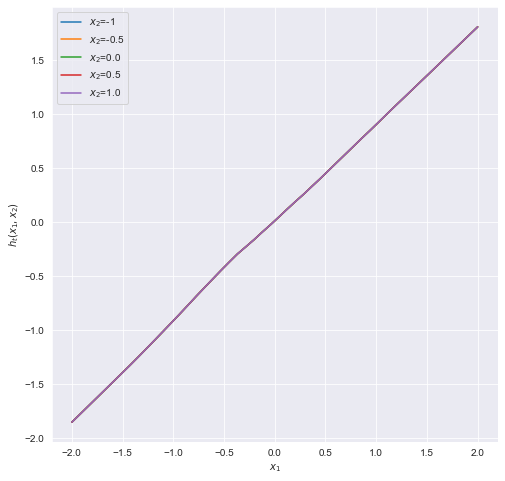

In [29]:
num = 50
consts = [-1, -0.5, 0., 0.5, 1.0]

xs = np.linspace(-2, 2, num=num)
X = np.zeros((50, 2))
X[:, 0] = xs
Xs = []
for c in consts:
    X[:, 1] = c
    Xs.append(X)

fig = plt.figure(figsize=(8,8))
with torch.no_grad():
    for i, X in enumerate(Xs):
        y_hat = network.forward(torch.tensor(X, dtype=torch.float32))
        plt.plot(xs, y_hat.detach().numpy(), label='$x_2$={}'.format(consts[i]))

plt.xlabel('$x_1$')
plt.ylabel('$h_t(x_1, x_2)$')
plt.legend()
plt.show()

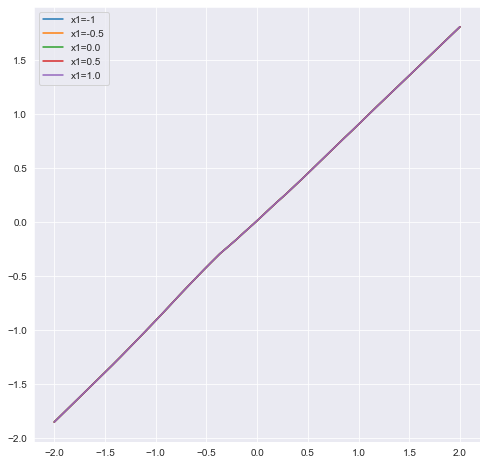

In [22]:
num = 50
consts = [-1, -0.5, 0., 0.5, 1.0]

xs = np.linspace(-2, 2, num=num)
X = np.zeros((50, 2))
X[:, 0] = xs
Xs = []
for c in consts:
    X[:, 1] = c
    Xs.append(X)

fig = plt.figure(figsize=(8,8))
with torch.no_grad():
    for i, X in enumerate(Xs):
        y_hat = network.forward(torch.tensor(X, dtype=torch.float32))
        plt.plot(xs, y_hat.detach().numpy(), label='$x_2$={}'.format(consts[i]))

plt.xlabel('$x_1$')
plt.ylabel('$h_t(x_1, x_2)$')
plt.legend()
plt.show()

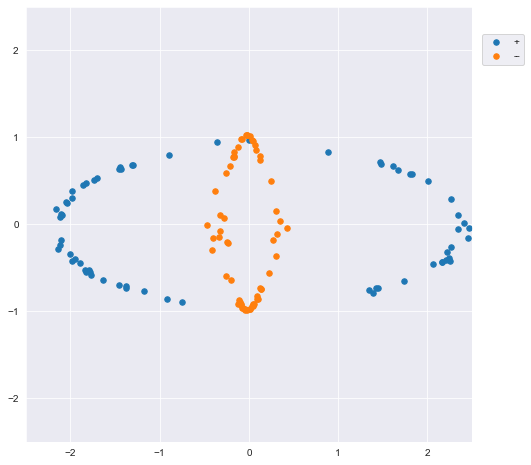

In [14]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[5000], signs, s=30)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()

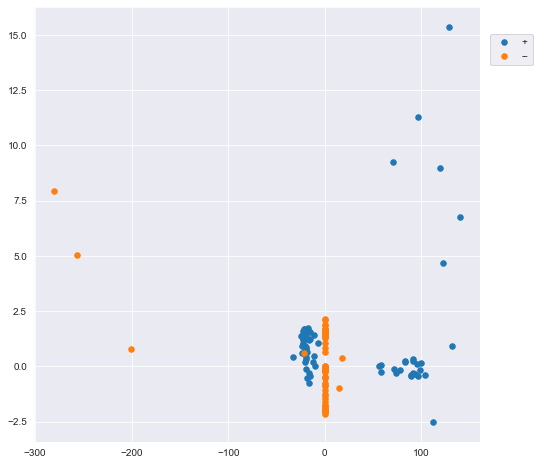

In [25]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[5000], signs, s=30)
plt.show()

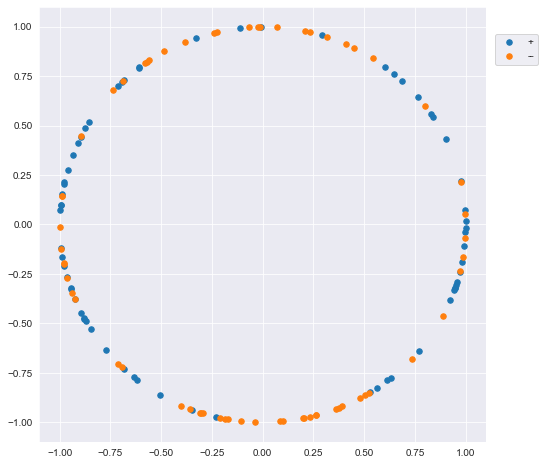

In [21]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, normalized_neurons[2000], signs, s=30)
plt.show()

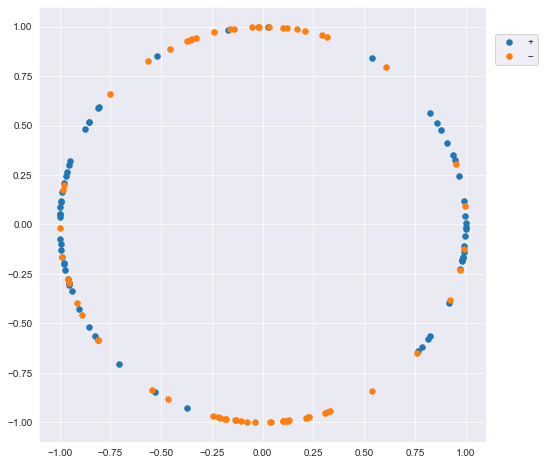

In [26]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, normalized_neurons[5000], signs, s=30)
plt.show()

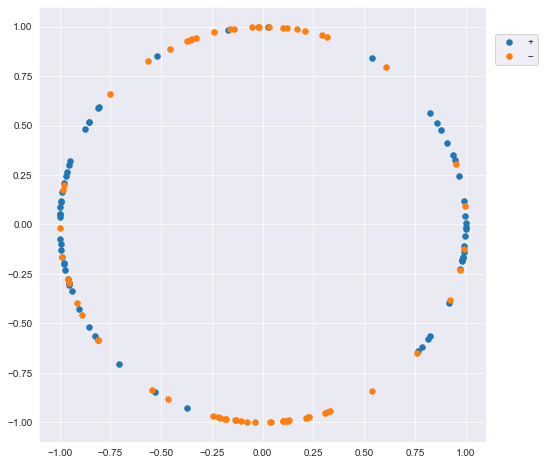

In [19]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, normalized_neurons[5000], signs, s=30)
plt.show()

In [17]:
if batch_size is None:
    batch_size = n_samples

In [12]:
# figsize = (8, 8)
    # fig = plt.figure(figsize=figsize)
    # 
    # cmpt_steps = 0
    # batch_index = 0
    # while cmpt_steps < 40:
    #     with torch.no_grad():
    #         plot_neurons_3d(fig, neurons=network.input_layer.weight.data.detach().numpy(), signs=signs)
    #         fig_path = os.path.join(FIGURES_DIR, 'step_{}.png'.format(cmpt_steps))
    #         plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)
    #         fig.canvas.draw()
    #         # plt.pause(pause)
    #         fig.canvas.flush_events()
    # 
    #     if batch_index >= n_samples:
    #         batch_index = 0
    #     # batch inputs and targets
    #     batch_x = X[batch_index: batch_index + batch_size, :]
    #     batch_y = y[batch_index: batch_index + batch_size]
    #     batch_index += batch_index + batch_size
    # 
    #     # forward
    #     y_hat = network.forward(batch_x)
    #     loss_ = loss(y_hat, batch_y)
    # 
    #     # backward and gradient step
    #     print(loss_.detach().item())
    #     loss_.backward()
    #     optimizer.step()
    # 
    #     cmpt_steps += 1
    # 
    # with torch.no_grad():
    #     plot_neurons_3d(fig, neurons=network.input_layer.weight.data.detach().numpy(), signs=signs)
    #     fig_path = os.path.join(FIGURES_DIR, 'step_{}.png'.format(cmpt_steps))
    #     plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)
    #     fig.canvas.draw()
    #     # plt.pause(pause)
    #     fig.canvas.flush_events()

## Plot loss

In [18]:
losses = []
neurons = [network.input_layer.weight.data.detach().clone().numpy()]
# fig = plt.figure(figsize=(8,8))

cmpt_steps = 0
batch_index = 0
while cmpt_steps < 500:
    #plot_neurons_3d(fig, neurons=network.input_layer.weight.data.detach().numpy(), signs=signs)
    #fig_path = os.path.join(FIGURES_DIR, 'bias', 'step_{}.png'.format(cmpt_steps))
    #plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)
    
    if batch_index >= n_samples:
        batch_index = 0
    # batch inputs and targets
    batch_x = X[batch_index: batch_index + batch_size, :]
    batch_y = y[batch_index: batch_index + batch_size]
    batch_index += batch_index + batch_size

    # forward
    y_hat = network.forward(batch_x)
    loss_ = loss(y_hat, batch_y)

    # backward and gradient step
    # print(loss_.detach().item())
    losses.append(loss_.detach().item())
    loss_.backward()
    optimizer.step()
    
    neurons.append(network.input_layer.weight.data.detach().clone().numpy())

    cmpt_steps += 1
    
#plot_neurons_3d(fig, neurons=network.input_layer.weight.data.detach().numpy(), signs=signs)
#fig_path = os.path.join(FIGURES_DIR, 'bias', 'step_{}.png'.format(cmpt_steps))
#plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

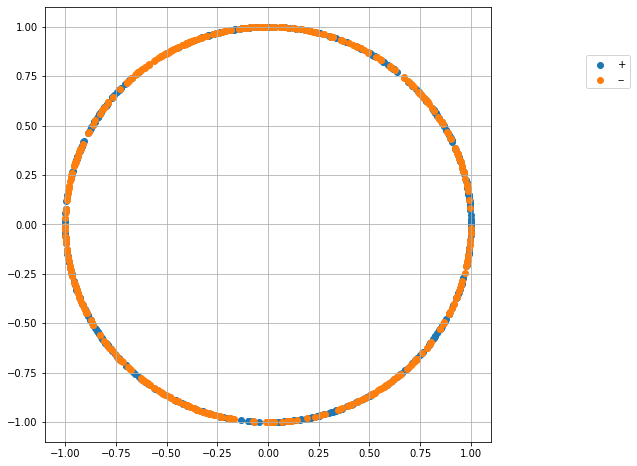

In [20]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[0], signs)
plt.show()

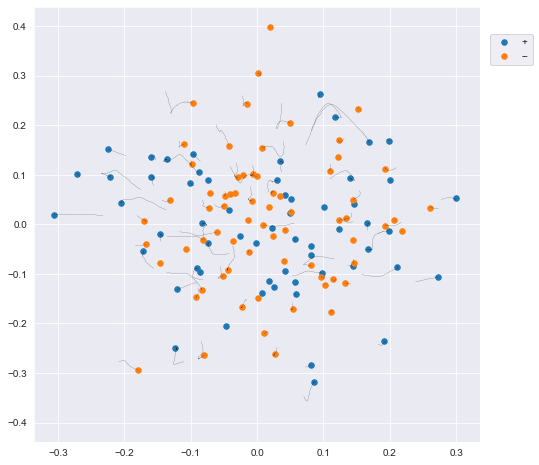

In [34]:
fig = plt.figure(figsize=(8,8))
plot_neurons_trajectory_2d(fig, neurons[:1000], signs, linewidth=0.15, s=30)
plt.show()

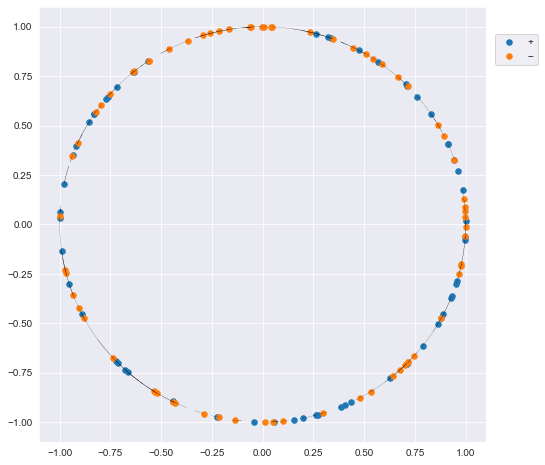

In [35]:
fig = plt.figure(figsize=(8,8))
plot_neurons_trajectory_2d(fig, normalized_neurons[:1000], signs, linewidth=0.15, s=30)
plt.show()

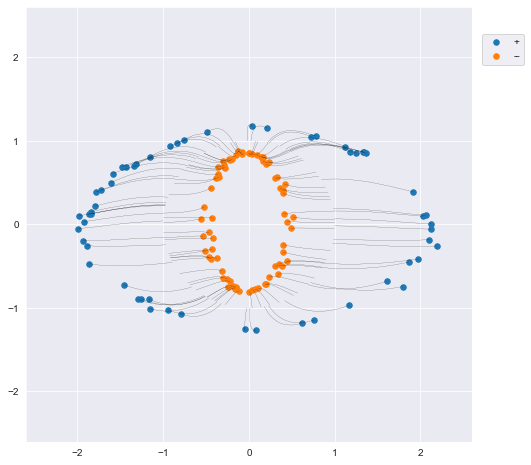

In [21]:
fig = plt.figure(figsize=(8,8))
M = max(np.max(np.abs(neurons[:, :, 0])), np.max(np.abs(neurons[:, :, 1])))
plt.xlim(-M, M)
plt.ylim(-M, M)
plot_neurons_trajectory_2d(fig, neurons[:3000], signs, linewidth=0.15, s=30)
plt.xlim(-M, M)
plt.ylim(-M, M)
plt.show()

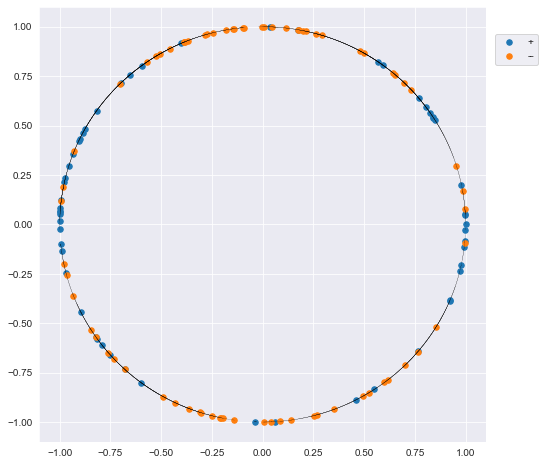

In [31]:
fig = plt.figure(figsize=(8,8))
M = max(np.max(np.abs(normalized_neurons[:, :, 0])), np.max(np.abs(normalized_neurons[:, :, 1])))
plot_neurons_trajectory_2d(fig, normalized_neurons[:3000], signs, linewidth=0.15, s=30)
plt.show()

In [25]:
normalized_neurons.shape

(5001, 128, 2)

In [30]:
(normalized_neurons[100, 121, :] ** 2).sum()

1.0000001

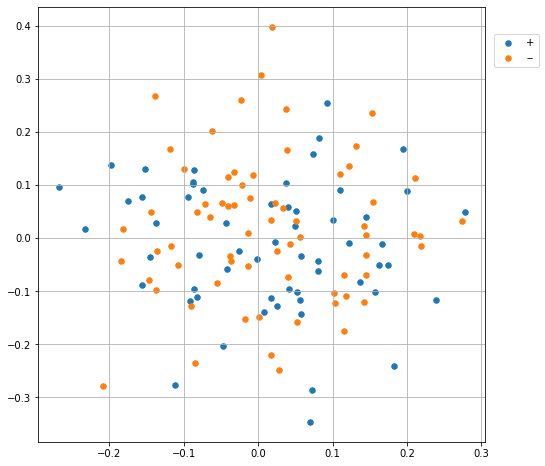

In [18]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[0], signs, s=30)
plt.show()

## Plot dynamics and save for movie

In [ ]:
M = 1.05 * max(np.max(np.abs(neurons[:, :, 0])), np.max(np.abs(neurons[:, :, 1])))
for t in range(min(5000, len(neurons))):
    if t % 100 == 0:
        print(t)
    fig = plt.figure(figsize=(8,8))
    plot_neurons_trajectory_2d(fig, neurons[:t+1, :, :], signs, linewidth=0.15, s=30)
    plt.xlim(-M, M)
    plt.ylim(-M, M)
    plt.savefig(os.path.join(FIGURES_DIR, 'neurons_{}.jpeg'.format(t)))
    plt.close()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [22]:
plot_every = 10
for t in range(min(5000, len(neurons))):
    if t % 500 == 0:
        print(t)
    if t % plot_every == 9:
        fig = plt.figure(figsize=(8,8))
        plot_neurons_2d(fig, normalized_neurons[t, :, :], signs, s=30)
        plt.savefig(os.path.join(FIGURES_DIR, 'neurons_{}.jpeg'.format(t)))
        plt.close()

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [ ]:
for t in range(min(5000, len(neurons))):
    fig = plt.figure(figsize=(8,8))
    plot_neurons_trajectory_2d(fig, normalized_neurons[:t+1, :, :], signs, linewidth=0.15, s=30)
    plt.savefig(os.path.join(FIGURES_DIR, 'neurons_{}.jpeg'.format(t)))
    plt.close()

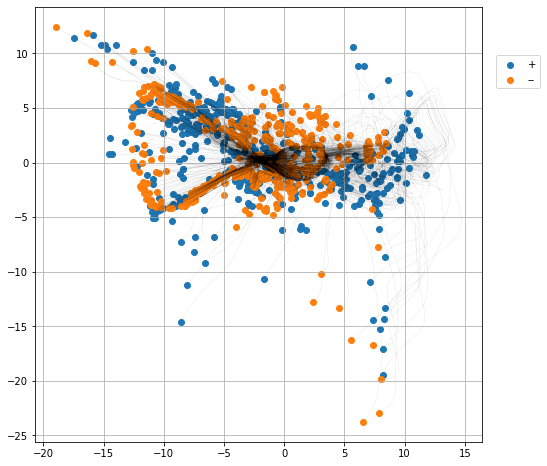

In [23]:
fig = plt.figure(figsize=(8,8))
plot_neurons_trajectory_2d(fig, neurons, signs)
plt.show()

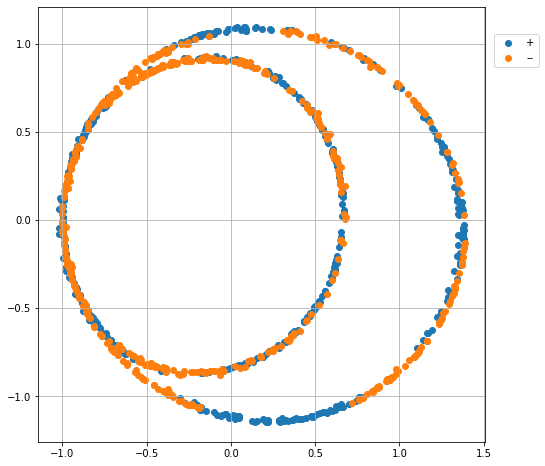

In [40]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[18], signs)
plt.show()

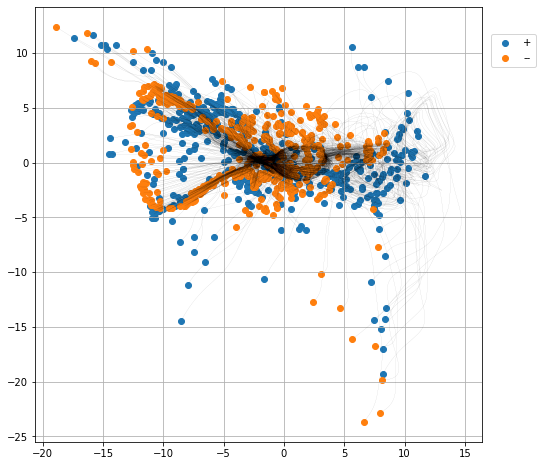

In [56]:
fig = plt.figure(figsize=(8,8))
plot_neurons_trajectory_2d(fig, neurons[:500], signs)
plt.show()

In [57]:
loss_

tensor(0.2279, grad_fn=<MseLossBackward0>)

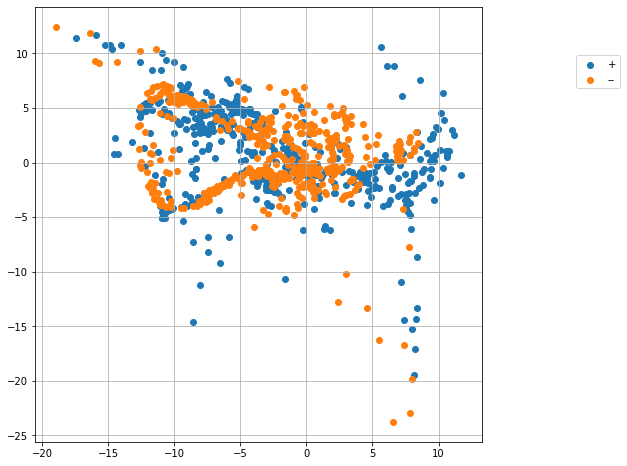

In [21]:
fig = plt.figure(figsize=(8,8))
plot_neurons_2d(fig, neurons[-1], signs)
plt.show()

0
1
2
3
4
5
6
7


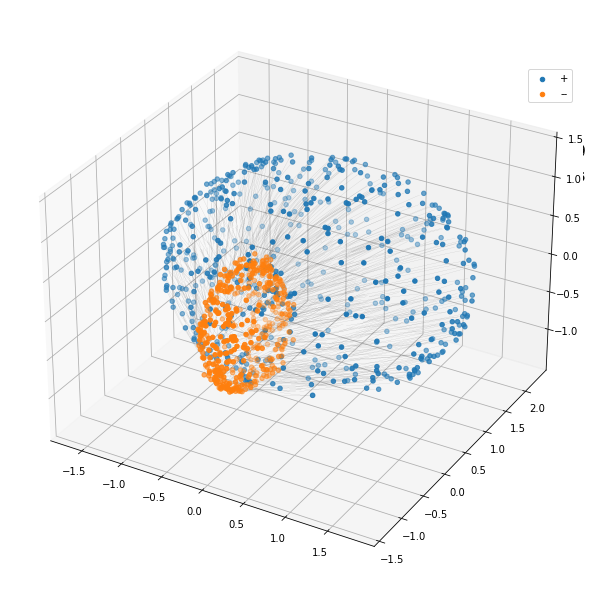

In [31]:
fig = plt.figure(figsize=(8,8))
plot_neurons_3d(fig, neurons=neurons[0], signs=signs)
fig_path = os.path.join(FIGURES_DIR, 'bias', 'trajectory', 'step_{}.png'.format(0))
plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)
for i in range((len(neurons) // 5)):
    print(i)
    plot_neurons_trajectory_3d(fig, neurons=neurons[:5 * (i+1)], signs=signs)
    fig_path = os.path.join(FIGURES_DIR, 'bias', 'trajectory', 'step_{}.png'.format(5 * (i+1)))
    plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

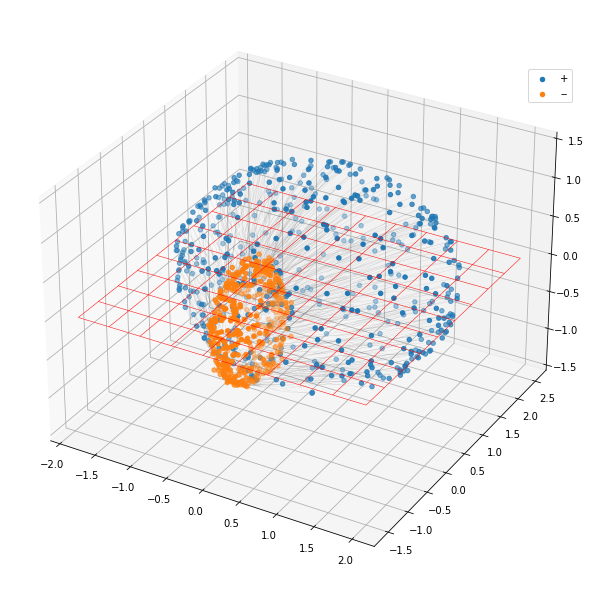

In [93]:
fig = plt.figure(figsize=(8,8))
plot_neurons_trajectory_3d(fig, neurons=neurons, signs=signs, show_plane=True)
plt.show()

In [21]:
num = 5
xs = np.linspace(-4, 4, num=5, endpoint=True)
ys = np.linspace(-4, 4, num=5, endpoint=True)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)

/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_24920/3439503141.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, auto_add_to_figure=True)


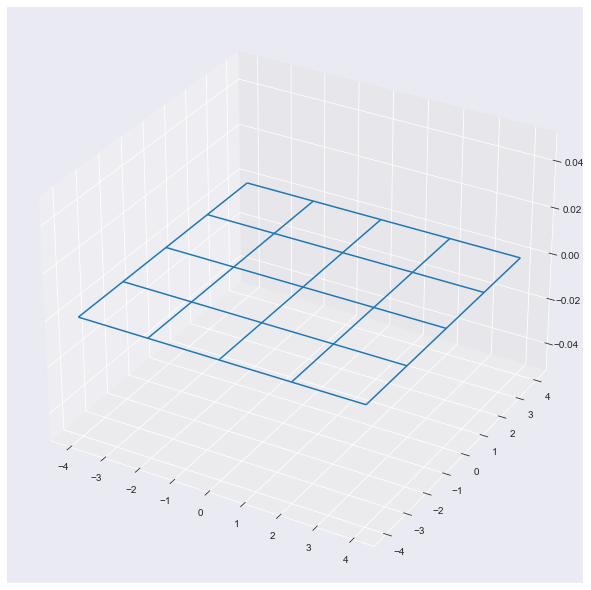

In [22]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig, auto_add_to_figure=True)
ax.plot_wireframe(X, Y, Z)
plt.show()